# TGS Salt Identification Challenge
## Segment salt deposits beneath the Earth's surface

Several areas of Earth with large accumulations of oil and gas also have huge deposits of salt below the surface.

But unfortunately, knowing where large salt deposits are precisely is very difficult. Professional seismic imaging still requires expert human interpretation of salt bodies. This leads to very subjective, highly variable renderings. More alarmingly, it leads to potentially dangerous situations for oil and gas company drillers.

To create the most accurate seismic images and 3D renderings, TGS (the world’s leading geoscience data company) is hoping Kaggle’s machine learning community will be able to build an algorithm that automatically and accurately identifies if a subsurface target is salt or not.

### Dataset: https://www.kaggle.com/c/tgs-salt-identification-challenge/data

In [1]:
! wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10151/59042/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586444582&Signature=gOljnbjB5OvP4FVSOHsfW5VZ%2F0uYmqqQezFg48aB0eveE64U3zZzzrgAwLp4tVhC9Vf8YJoOywQvBKS9U6lDfuRGZC8uMC%2BusEyHS%2FqJQSwLoJ9MfuqTPFxz%2B%2BxWOonSprVQ7LaFOU0bqWpCsrF%2Fo9Q2EtETvKEfq0aAzzoKBc9N7%2BOg7288FUsJXjJwjZSKwpT3DnACPuUbSqF%2BcuuEMYLvF1WyMH%2FvQZifw2P2YdBYKBXDztDI3TY%2FC4cfOYuBKPpaHClaBxGX1nxazJhtFkqerDvP2doqSxh6rxuWufYF8JY4JD9eazvaffv3%2FM6ZKgk0aA7tB%2F7mgmsIEbZXzg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtgs-salt-identification-challenge.zip" -c -O 'tgs-salt-identification-challenge.zip'

--2020-04-07 08:01:02--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10151/59042/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586444582&Signature=gOljnbjB5OvP4FVSOHsfW5VZ%2F0uYmqqQezFg48aB0eveE64U3zZzzrgAwLp4tVhC9Vf8YJoOywQvBKS9U6lDfuRGZC8uMC%2BusEyHS%2FqJQSwLoJ9MfuqTPFxz%2B%2BxWOonSprVQ7LaFOU0bqWpCsrF%2Fo9Q2EtETvKEfq0aAzzoKBc9N7%2BOg7288FUsJXjJwjZSKwpT3DnACPuUbSqF%2BcuuEMYLvF1WyMH%2FvQZifw2P2YdBYKBXDztDI3TY%2FC4cfOYuBKPpaHClaBxGX1nxazJhtFkqerDvP2doqSxh6rxuWufYF8JY4JD9eazvaffv3%2FM6ZKgk0aA7tB%2F7mgmsIEbZXzg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtgs-salt-identification-challenge.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; nothing 

In [0]:
import zipfile
with zipfile.ZipFile("/content/tgs-salt-identification-challenge.zip","r") as f:
  f.extractall()

In [0]:
with zipfile.ZipFile('/content/flamingo.zip', 'r') as f:
  f.extractall('/content/flamingo')

In [0]:
with zipfile.ZipFile('/content/train.zip') as f:
  f.extractall('/content/train')

In [0]:
with zipfile.ZipFile('/content/test.zip') as f:
  f.extractall('/content/test')

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from tqdm import notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation,\
                                    Dense, Dropout, MaxPooling2D, GlobalMaxPool2D, Lambda, \
                                    RepeatVector, Reshape, concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [7]:
# This has three components ('/content/train/images', [], ['64e79513a3.png',...4000 images])

train_images= next(os.walk('/content/train/images'))        
print(len(train_images))

# Images are in 3rd position hence train_images[2] / train_masks[2]
print('No of images in train data:', len(train_images[2]))

train_masks= next(os.walk('/content/train/masks'))
print('No of masks in train data:', len(train_masks[2]))


3
No of images in train data: 4000
No of masks in train data: 4000


In [8]:
df= pd.read_csv(r'/content/train.csv')
print(df.shape)
print(df.head())

(4000, 2)
           id                                           rle_mask
0  575d24d81d                                                NaN
1  a266a2a9df                                          5051 5151
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [9]:
# We observe zero nulls in 'id' column but 1562 NaNs in 'rle_mask' column
df.isnull().sum()

id             0
rle_mask    1562
dtype: int64

In [10]:
# we find the extension is '.png'
print(train_images[2][0])
print(train_masks[2][0])

f409d55fee.png
f409d55fee.png


#### Below code can be used to visualize the images and corresponding masks

(101, 101, 3)
(101, 101, 3)
(101, 101, 3)
(101, 101)
(101, 101)
(101, 101)


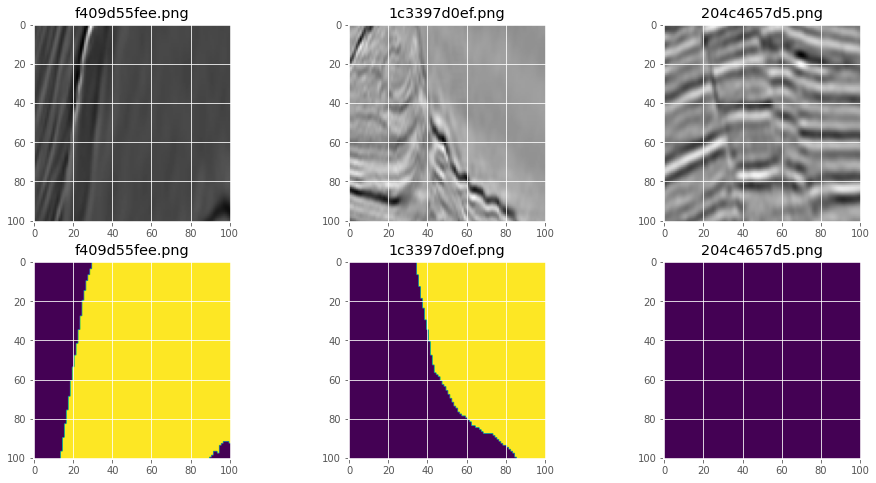

In [11]:
# We now check sample images

path= '/content/train/images/'     # the path is provided
key= train_images[2][:3]

path_mask= '/content/train/masks/' # the path is provided
key_mask= train_masks[2][:3]

image= []
title= []

for i in key[:3]:
  image.append(path+i) 
  title.append(i)

for i in key_mask[:3]:
  image.append(path_mask+i)
  title.append(i)

plt.figure(figsize= (16, 8))
for i in range(6):
  plt.subplot(2, 3, i+1)
  j= plt.imread(image[i])
  print(j.shape)
  plt.imshow(j)
  plt.title(title[i])

plt.show()

In [12]:
# check the min and max sizes of images

import time
start= time.time()

# We check the max and min shape of images
width=[]
height=[]
for i in train_images[2][:]:
  j= plt.imread(path+i)
  w, h, channel= j.shape
  width.append(w)
  height.append(h)


print('Max Width: ', max(width))
print('Min Width: ', min(width))
print('Max Height: ', max(height))
print('Min Height: ', min(height))
print("Time Taken is: " + str(time.time() - start))

Max Width:  101
Min Width:  101
Max Height:  101
Min Height:  101
Time Taken is: 3.57474946975708


#### Load the images and masks into arrays

In [0]:
# Reshape the image from 101, 101, 3 to 128, 128, 1
im_height= 128
im_width= 128

X = np.zeros((4000, im_height, im_width, 1), dtype=np.float32)
y = np.zeros((4000, im_height, im_width, 1), dtype=np.float32)

In [0]:

for i, j in enumerate(train_images[2][:]):
    # Load images
    img = load_img(path+j, color_mode= 'grayscale')
    img = img_to_array(img)
    img = resize(img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[i] = img / 255.0
    

for i, j in enumerate(train_masks[2][:]):
    # Load masks
    mask = img_to_array(load_img(path_mask+j, color_mode= 'grayscale'))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    y[i] = mask / 255.0

In [16]:
print('Shape of X:', X.shape)
print('Shape of Y:', y.shape)

Shape of X: (4000, 128, 128, 1)
Shape of Y: (4000, 128, 128, 1)


In [17]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

Shape of X_train: (3600, 128, 128, 1)
Shape of y_train: (3600, 128, 128, 1)


In [18]:
print('Shape of X:', X_valid.shape)
print('Shape of Y:', y_valid.shape)

Shape of X: (400, 128, 128, 1)
Shape of Y: (400, 128, 128, 1)


In [0]:
# To define a conv2D block (2 times conv2D)

def conv2d_block(input_tensor, filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size), activation=  'relu', \
               padding = 'same' )(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    
    # second layer
    x = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size), activation=  'relu', \
               padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    
    return x

## U-NET Architechture

* Encoder part => (16, 16), (32, 32), (64, 64), (128, 128), 256
* Decoder part => [128, (256, 256), 128], [64, (128, 128), 64], [32, (64, 64), 32], [16, (32, 32), 16], 1
     

In [0]:

def get_unet(input_img, filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [33]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [0]:
callbacks= [ EarlyStopping(monitor= 'val_loss', patience= 10, verbose= 1),
             ReduceLROnPlateau(monitor= 'val_loss', patience= 5, min_lr= 0.001, verbose= 1),
             ModelCheckpoint(filepath= '/content/model-tgs-salt.h5', monitor= 'val_loss', verbose= 1, save_best_only= True, 
                            save_weights_only= True )
             ]

In [34]:
history= model.fit(x= X_train, y= y_train, batch_size= 32, epochs= 50, verbose= 1, callbacks= callbacks, 
                   validation_data= (X_valid, y_valid))

Epoch 1/50
113/113 [==============================] - ETA: 0s - loss: 0.4697 - accuracy: 0.8218
Epoch 00001: val_loss did not improve from 0.24889
113/113 [==============================] - 5s 46ms/step - loss: 0.4697 - accuracy: 0.8218 - val_loss: 2.5187 - val_accuracy: 0.2845 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - ETA: 0s - loss: 0.3309 - accuracy: 0.8750
Epoch 00002: val_loss did not improve from 0.24889
113/113 [==============================] - 5s 41ms/step - loss: 0.3309 - accuracy: 0.8750 - val_loss: 1.5341 - val_accuracy: 0.2952 - lr: 0.0010
Epoch 3/50
113/113 [==============================] - ETA: 0s - loss: 0.2837 - accuracy: 0.8876
Epoch 00003: val_loss did not improve from 0.24889
113/113 [==============================] - 5s 41ms/step - loss: 0.2837 - accuracy: 0.8876 - val_loss: 0.9180 - val_accuracy: 0.5301 - lr: 0.0010
Epoch 4/50
113/113 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.8967
Epoch 00004: val_loss did no

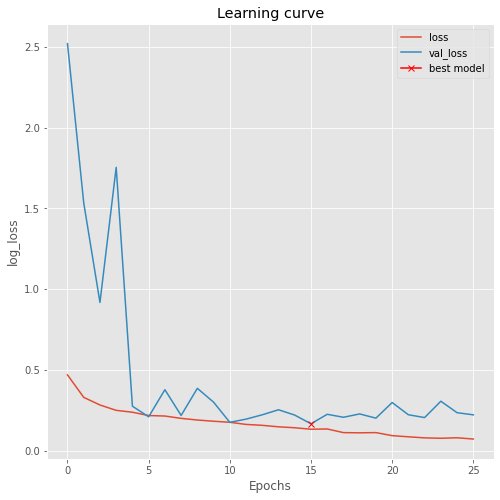

In [37]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

### Inference

In [0]:
# load the best model
model.load_weights('/content/model-tgs-salt.h5')

In [40]:
score = model.evaluate(x = X_valid, y= y_valid)
print('Test Loss: ', score[0])
print()
print('Test Accuracy: ', score[1])

13/13 [==============================] - 0s 12ms/step - loss: 0.1674 - accuracy: 0.9270
Test Loss:  0.16743120551109314

Test Accuracy:  0.9269952178001404


In [41]:
train_pred= model.predict(x= X_train, verbose= 1)
val_pred= model.predict(x= X_valid)

113/113 [==============================] - 1s 13ms/step


In [0]:
# Threshold_predictions
train_pred_t= (train_pred > 0.5).astype(np.uint8)

val_pred_t= (val_pred > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

### Predit on Training set and Val set

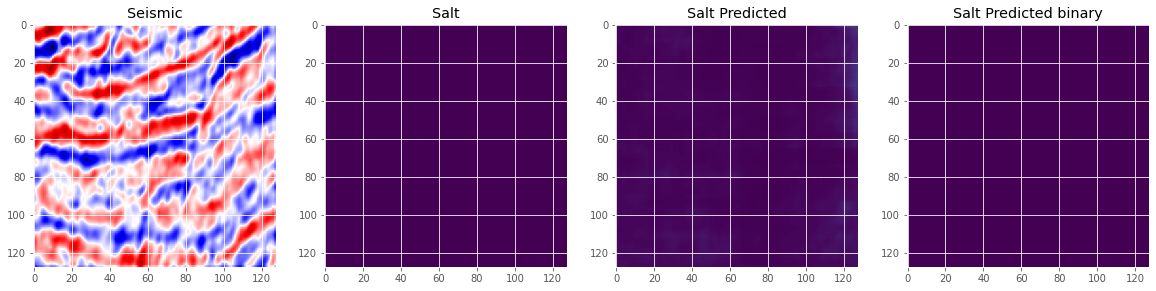

In [48]:
# Check if training data looks all right
# ix is any number between (1 - 3600)
plot_sample(X_train, y_train, train_pred, train_pred_t, ix=14)

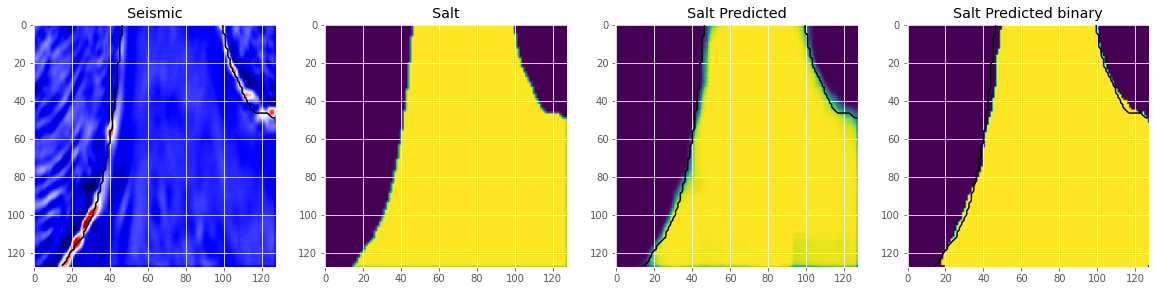

In [54]:
plot_sample(X_train, y_train, train_pred, train_pred_t, ix= 114)

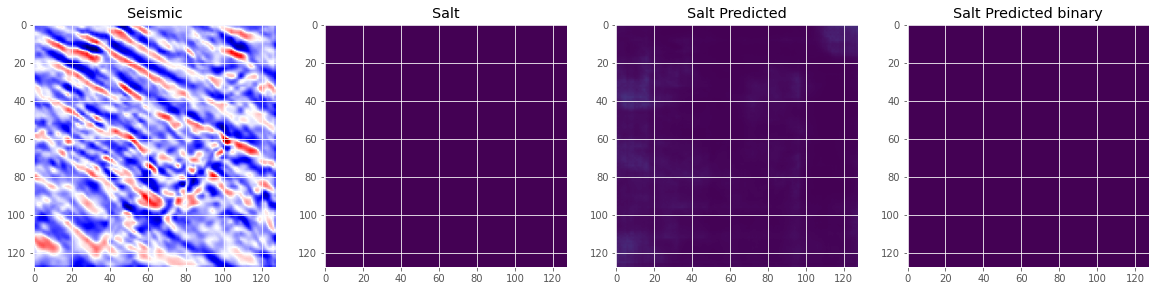

In [57]:
plot_sample(X_valid, y_valid, val_pred, val_pred_t, ix= 394)

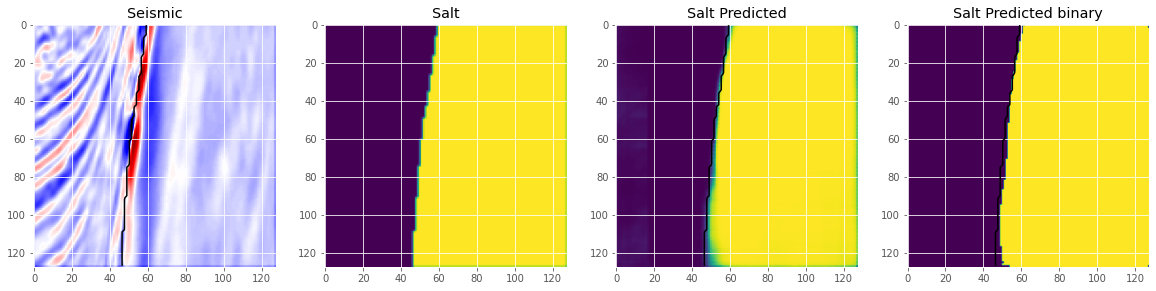

In [53]:
# ix is any number between (1 - 400)
plot_sample(X_valid, y_valid, val_pred, val_pred_t, ix= 30)